In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import collections

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)
    
import targeting

In [2]:
from __future__ import print_function, division

import numpy as np

from astropy import units as u
from astropy import table
from astropy.coordinates import SkyCoord
from astropy.visualization import hist as ahist

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

# Load the spectroscopic data

In [4]:
spec_data_raw = table.Table.read('SAGADropbox/data/saga_spectra_raw.fits.gz')
spec_data_raw

RA,DEC,MASKNAME,specobjid,SPEC_Z,ZQUALITY,TELNAME,SPEC_REPEAT
float64,float64,str80,float64,float64,int64,str6,str6
136.045125,25.1698611111,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,98.0,0.0907368659973,4,WIYN,WIYN
136.23275,25.6625555556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,88.0,0.0832283496857,4,WIYN,WIYN
136.503833333,25.4698055556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,84.0,0.0095317363739,4,WIYN,WIYN
136.879625,25.1723055556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,83.0,0.084725856781,4,WIYN,WIYN
136.182541667,25.3763611111,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,82.0,0.183461755514,3,WIYN,WIYN
136.421875,25.5417777778,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,81.0,0.0095317363739,4,WIYN,WIYN
136.466416667,25.3593055556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,80.0,0.0862255096436,4,WIYN,WIYN
136.541083333,25.4299722222,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,78.0,0.0088347196579,4,WIYN,WIYN
136.252791667,25.2895,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,73.0,0.0533706918359,4,WIYN,WIYN


Hmm, the specobjid's are floats, but they should be integers to avoid possible rounding errors during comparison.  Lets fix that:

In [5]:
# Just setting the dtype does *not* do the conversion of the values. It instead tells numpy to 
# re-interpret the same set of bits  as thought they were ints.
# So we do the first and third line below to update the values - `astype` *does* do the conversion

spec_data = spec_data_raw.copy()
spec_data['specobjid'].dtype = int
spec_data['specobjid'] = spec_data_raw['specobjid'].astype(int)

spec_data

/Users/erik/miniconda3/envs/anaconda2/lib/python2.7/site-packages/astropy/table/column.py:1095: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


RA,DEC,MASKNAME,specobjid,SPEC_Z,ZQUALITY,TELNAME,SPEC_REPEAT
float64,float64,str80,int64,float64,int64,str6,str6
136.045125,25.1698611111,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,98,0.0907368659973,4,WIYN,WIYN
136.23275,25.6625555556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,88,0.0832283496857,4,WIYN,WIYN
136.503833333,25.4698055556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,84,0.0095317363739,4,WIYN,WIYN
136.879625,25.1723055556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,83,0.084725856781,4,WIYN,WIYN
136.182541667,25.3763611111,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,82,0.183461755514,3,WIYN,WIYN
136.421875,25.5417777778,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,81,0.0095317363739,4,WIYN,WIYN
136.466416667,25.3593055556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,80,0.0862255096436,4,WIYN,WIYN
136.541083333,25.4299722222,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,78,0.0088347196579,4,WIYN,WIYN
136.252791667,25.2895,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,73,0.0533706918359,4,WIYN,WIYN


# Find matches

First we see if we can match on spectroscopic ID's

In [6]:
sid = spec_data['specobjid']
len(np.unique(sid)), len(sid)

(428, 95475)

Hmm... far too few specobjids.  Probably whatever converted to a float above also led to some mis-casting of the ID's.  So we'll fall back on doing matching based on sky coordinates.

In [7]:
scs = SkyCoord(spec_data['RA'], spec_data['DEC'], unit=u.deg)

This identifies all pairs if coordinates that are within 5" of each other:

In [8]:
idx1, idx2, sep2d, _ = scs.search_around_sky(scs, 5*u.arcsec)

Because we matched `scs` to itself, this list also inclues "self-matches" where the pairs are an object and itself. But we want these to make sure we get the single-object "groups"

## Are they really groups? 

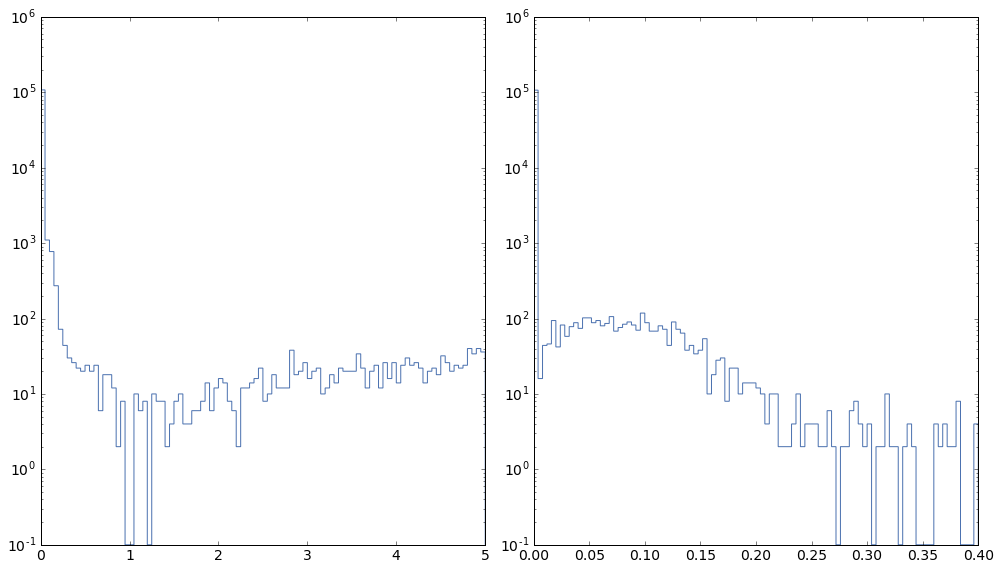

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(sep2d.to(u.arcsec).value, bins=100, range=(0, 5), histtype='step', log=True)
plt.xlim(0, 5)
ax2.hist(sep2d.to(u.arcsec).value, bins=100, range=(0, .4), histtype='step', log=True)
plt.xlim(0, .4)
plt.tight_layout()

Lets have a quick look at the things that are between $.1"$ and $.2"$ to see if they are matches or shreds

In [10]:
msk = (.1*u.arcsec<sep2d)&(sep2d<.2*u.arcsec)
random25 = np.random.permutation(np.sum(msk))[:25]

scs1 = scs[idx1[msk][random25]]
scs2 = scs[idx2[msk][random25]]

print(targeting.sampled_imagelist(scs1, None, n=len(scs1)))
print(targeting.sampled_imagelist(scs2, None, n=len(scs2)))

name ra dec
0 248.20029258 19.552103043
1 354.329650879 0.538355529
2 335.708770752 -3.736660957
3 354.114776611 0.458099961
4 221.926 -0.160820007324
5 247.73454666 20.10562706
6 335.72052002 -3.257227659
7 247.867271752 20.0116969105
8 353.671569824 0.321311086
9 353.780303955 0.016202778
10 179.798904419 -1.069113851
11 353.68601 0.4252313
12 248.244736347 20.215039632
13 335.911193848 -3.733205318
14 247.867615526 20.1481754573
15 354.31930542 0.336699992
16 354.028501515 0.529156983
17 222.122238159 -0.147338882
18 335.600189209 -3.533974886
19 335.676147827 -3.41305228981
20 39.2811842933 -0.996488197292
21 354.262695312 0.472708315
22 248.428312025 19.4795910062
23 335.900403508 -3.74021119083
24 354.02309 0.38311279
name ra dec
0 248.200274822 19.5521274631
1 354.32968 0.53835535
2 335.708806422 -3.7366588525
3 354.11481 0.45810078
4 221.926034619 -0.160829253093
5 247.734583333 20.1056388889
6 335.720552057 -3.25720776954
7 247.86729813 20.01171875
8 353.671606257 0.3213147315

Inspection of these reveals them to be the same objects. Most be difference between different DR's or similar.  So we define matches as simply anything within $.4"$

In [11]:
grpdct = {}
grpi = 0
for i1, i2 in zip(idx1, idx2):
    if i1 in grpdct:
        if i2 in grpdct:
            # combine the two groups by assigning grp2 items to grp1
            
            # this block is by far the slowest part so if the data size grows it should be optimized
            grp1 = grpdct[i1]
            grp2 = grpdct[i2]
            if grp1 != grp2:
                to_set_to_1 = [i for i, grp in grpdct.iteritems() if grp==grp2]
                for i in to_set_to_1:
                    grpdct[i] = grp1
        else:
            #add i2 to the group i1 is already in
            grpdct[i2] = grpdct[i1]
    else:
        if i2 in grpdct:
            #add i1 to the group i2 is already in
            grpdct[i2] = grpdct[i1]
        else:
            # add them both to a new group
            grpdct[i1] = grpdct[i2] = grpi
            grpi += 1
            
len(idx1), len(idx2), len(np.unique(grpdct.keys())), len(np.unique(grpdct.values()))

(111123, 111123, 95475, 91748)

# Now convert the lists of pairs into groups 

In [12]:
grpnum_to_group_members = collections.defaultdict(list)
for k, v in grpdct.iteritems():
    grpnum_to_group_members[v].append(k)
    
# convert the members into arrays
grpnum_to_group_members = {k:np.array(v) for k, v in grpnum_to_group_members.iteritems()}

In [13]:
# this is the count *before* the IMACS fix:
{1: 88822,
 2: 2460,
 3: 293,
 4: 79,
 5: 19,
 6: 6,
 7: 5,
 8: 1,
 9: 2,
 10: 3,
 13: 1,
 34: 1,
 54: 1,
 64: 1,
 72: 1,
 79: 1}

{1: 88822,
 2: 2460,
 3: 293,
 4: 79,
 5: 19,
 6: 6,
 7: 5,
 8: 1,
 9: 2,
 10: 3,
 13: 1,
 34: 1,
 54: 1,
 64: 1,
 72: 1,
 79: 1}

In [14]:
# this counts how many have a certain number of elements in their group
counts = np.bincount([len(arr) for arr in grpnum_to_group_members.values()])
{i:c  for i, c in enumerate(counts) if c != 0}

{1: 88774,
 2: 2508,
 3: 341,
 4: 87,
 5: 19,
 6: 6,
 7: 5,
 8: 1,
 9: 2,
 10: 3,
 13: 1,
 79: 1}

79 seems like a lot... What's the deal with the big ones?

In [29]:
Groupnum = collections.namedtuple('Groupnum', ['nobjs', 'grpnum'])
big_grps = sorted([Groupnum(len(arr), idx) for idx, arr in grpnum_to_group_members.iteritems() if len(arr)>5])
big_grps

[Groupnum(nobjs=6, grpnum=704),
 Groupnum(nobjs=6, grpnum=705),
 Groupnum(nobjs=6, grpnum=75752),
 Groupnum(nobjs=6, grpnum=76358),
 Groupnum(nobjs=6, grpnum=78537),
 Groupnum(nobjs=6, grpnum=82401),
 Groupnum(nobjs=7, grpnum=76510),
 Groupnum(nobjs=7, grpnum=78507),
 Groupnum(nobjs=7, grpnum=78515),
 Groupnum(nobjs=7, grpnum=78570),
 Groupnum(nobjs=7, grpnum=78638),
 Groupnum(nobjs=8, grpnum=75614),
 Groupnum(nobjs=9, grpnum=75656),
 Groupnum(nobjs=9, grpnum=75658),
 Groupnum(nobjs=10, grpnum=75597),
 Groupnum(nobjs=10, grpnum=75619),
 Groupnum(nobjs=10, grpnum=75640),
 Groupnum(nobjs=13, grpnum=75578),
 Groupnum(nobjs=79, grpnum=1643)]

In [31]:
spec_data[grpnum_to_group_members[big_grps[-1].grpnum]]

RA,DEC,MASKNAME,specobjid,SPEC_Z,ZQUALITY,TELNAME,SPEC_REPEAT
float64,float64,str80,int64,float64,int64,str6,str6
39.616664886,-1.44213891,NS39_1_02_,2,0.247728,3,IMACS,IMACS
39.616664886,-1.44213891,NS39_1_100,10,0.363076,4,IMACS,IMACS
39.616664886,-1.44213891,NS39_1_101,11,0.630122,4,IMACS,IMACS
39.616664886,-1.44213891,NS39_1_102,12,0.425673,4,IMACS,IMACS
39.616664886,-1.44213891,NS39_1_103,13,0.181463,4,IMACS,IMACS
39.616664886,-1.44213891,NS39_1_104,14,0.260724,4,IMACS,IMACS
39.616664886,-1.44213891,NS39_1_105,15,0.18555,4,IMACS,IMACS
39.616664886,-1.44213891,NS39_1_106,16,0.135063,4,IMACS,IMACS
39.616664886,-1.44213891,NS39_1_107,17,0.286234,4,IMACS,IMACS


The above is just an example but the ones with the problem originally were IMACS targets...? So we have the option of ignoring all IMACS targets.

Marla fixed this after we realized it, though, so the remaining large groups are all MMT calibration stars:

In [37]:
spec_data[grpnum_to_group_members[big_grps[-2].grpnum]]

RA,DEC,MASKNAME,specobjid,SPEC_Z,ZQUALITY,TELNAME,SPEC_REPEAT
float64,float64,str80,int64,float64,int64,str6,str6
247.952642445,19.536758423,/Spectra/Final/MMT/spHect-2013.0508.zlog,18,-0.000915,4,MMT,MMT
247.952642445,19.536758423,/Spectra/Final/MMT/spHect-2013.0509_2.zlog,18,-0.000932,4,MMT,MMT
247.952642445,19.536758423,/Spectra/Final/MMT/spHect-2013.0509_3.zlog,18,-0.000923,4,MMT,MMT
247.952642445,19.536758423,/Spectra/Final/MMT/spHect-2013.0510_4.zlog,60,-0.000932,4,MMT,MMT
247.952642445,19.536758423,/Spectra/Final/MMT/spHect-2013.0510_5.zlog,10,-0.000893,4,MMT,MMT
247.952642445,19.536758423,/Spectra/Final/MMT/spHect-2013.0510_6.zlog,237,-0.000908,4,MMT,MMT
247.952642445,19.536758423,/Spectra/Final/MMT/spHect-2013.0531.zlog,60,-0.000881,4,MMT,MMT
247.952642445,19.536758423,/Spectra/Final/MMT/spHect-2013.0601.zlog,54,-0.000843,4,MMT,MMT
247.952642445,19.536758423,/Spectra/Final/MMT/spHect-2013.0602.zlog,264,-0.000881,4,MMT,MMT


In [152]:
idxs_to_keep = []
new_repeats = []
for grpnum, members in grpnum_to_group_members.iteritems():
    notimacs_members =  members[spec_data['TELNAME'][members]!='IMACS']
    if len(notimacs_members)==0:
        continue

    idxs_to_keep.append(notimacs_members[np.argsort(spec_data['ZQUALITY'][notimacs_members])[0]])
    new_repeats.append('+'.join(np.unique(spec_data['SPEC_REPEAT'][notimacs_members])))

In [153]:
unique_objs = spec_data[np.array(idxs_to_keep)]
del unique_objs['SPEC_REPEAT']
unique_objs['SPEC_REPEAT'] = new_repeats
unique_objs

RA,DEC,MASKNAME,specobjid,SPEC_Z,ZQUALITY,TELNAME,SPEC_REPEAT
float64,float64,str80,int64,float64,int64,str6,str15
136.045125,25.1698611111,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,98,0.0907368659973,4,WIYN,WIYN
136.23275,25.6625555556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,88,0.0832283496857,4,WIYN,WIYN
136.503833333,25.4698055556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,84,0.0095317363739,4,WIYN,WIYN
136.879625,25.1723055556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,83,0.084725856781,4,WIYN,WIYN
136.182541667,25.3763611111,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,82,0.183461755514,3,WIYN,WIYN
136.421875,25.5417777778,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,81,0.0095317363739,4,WIYN,WIYN
136.466416667,25.3593055556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,80,0.0862255096436,4,WIYN,WIYN
136.541083333,25.4299722222,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,78,0.0088347196579,4,WIYN,WIYN
136.252791667,25.2895,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,73,0.0533706918359,4,WIYN,WIYN


In [154]:
# double check that you sometimes get a combination of them together
np.unique(unique_objs['SPEC_REPEAT'])

AAT
AAT+DEIMOS+WIYN
AAT+GAMA
AAT+MMT
AAT+MMT+WIYN
AAT+WIYN
DEIMOS
DEIMOS+MMT
GAMA
GAMA+MMT
MMT


# Final Function

The function below just combines all the steps above into one function

In [1]:
from __future__ import print_function, division

import collections

import numpy as np

from astropy import units as u
from astropy import table
from astropy.coordinates import SkyCoord

In [2]:
def find_uniques(infn='saga_spectra_raw.fits.gz', remove_imacs=True, nearenough_sep=5*u.arcsec):
    spec_data_raw = table.Table.read(infn)
    
    if spec_data_raw['specobjid'].dtype.kind == 'i':
        spec_data = spec_data_raw
    else:
        #if the specobjid is not an int, convert the type of that column while retaining the value
        spec_data = spec_data_raw.copy()
        spec_data['specobjid'].dtype = int
        spec_data['specobjid'] = spec_data_raw['specobjid'].astype(int)

    scs = SkyCoord(spec_data['RA'], spec_data['DEC'], unit=u.deg)
    idx1, idx2, sep2d, _ = scs.search_around_sky(scs, nearenough_sep)
    
    # now contruct the groups from the pairs
    grpdct = {}
    grpi = 0
    for i1, i2 in zip(idx1, idx2):
        if i1 in grpdct:
            if i2 in grpdct:
                # combine the two groups by assigning grp2 items to grp1

                # this block is by far the slowest part so if the data size grows it should be optimized
                grp1 = grpdct[i1]
                grp2 = grpdct[i2]
                if grp1 != grp2:
                    to_set_to_1 = [i for i, grp in grpdct.iteritems() if grp==grp2]
                    for i in to_set_to_1:
                        grpdct[i] = grp1
            else:
                #add i2 to the group i1 is already in
                grpdct[i2] = grpdct[i1]
        else:
            if i2 in grpdct:
                #add i1 to the group i2 is already in
                grpdct[i2] = grpdct[i1]
            else:
                # add them both to a new group
                grpdct[i1] = grpdct[i2] = grpi
                grpi += 1
                
    grpnum_to_group_members = collections.defaultdict(list)
    for k, v in grpdct.iteritems():
        grpnum_to_group_members[v].append(k)
    # convert the members into arrays
    grpnum_to_group_members = {k:np.array(v) for k, v in grpnum_to_group_members.iteritems()}
    
    # identify which is the "best" spectrum (meaning the first zq=4 spectrum)
    idxs_to_keep = []
    new_repeats = []
    for grpnum, allmembers in grpnum_to_group_members.iteritems():
        if remove_imacs:
            members =  allmembers[spec_data['TELNAME'][allmembers]!='IMACS']
            if len(members)==0:
                continue
        else:
            members = allmembers
            
        idxs_to_keep.append(members[np.argsort(spec_data['ZQUALITY'][members])[0]])
        new_repeats.append('+'.join(np.unique(spec_data['SPEC_REPEAT'][members])))
    
    # now build the output table from the input
    unique_objs = spec_data[np.array(idxs_to_keep)]
    del unique_objs['SPEC_REPEAT']
    unique_objs['SPEC_REPEAT'] = new_repeats
    
    return unique_objs

uniq_objs = find_uniques('../saga_spectra_raw.fits.gz')

/Users/erik/miniconda3/envs/anaconda2/lib/python2.7/site-packages/astropy/table/column.py:1095: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [3]:
uniq_objs

RA,DEC,MASKNAME,specobjid,SPEC_Z,ZQUALITY,TELNAME,SPEC_REPEAT
float64,float64,str80,int64,float64,int64,str6,str15
136.045125,25.1698611111,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,98,0.0907368659973,4,WIYN,WIYN
136.23275,25.6625555556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,88,0.0832283496857,4,WIYN,WIYN
136.503833333,25.4698055556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,84,0.0095317363739,4,WIYN,WIYN
136.879625,25.1723055556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,83,0.084725856781,4,WIYN,WIYN
136.182541667,25.3763611111,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,82,0.183461755514,3,WIYN,WIYN
136.421875,25.5417777778,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,81,0.0095317363739,4,WIYN,WIYN
136.466416667,25.3593055556,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,80,0.0862255096436,4,WIYN,WIYN
136.541083333,25.4299722222,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,78,0.0088347196579,4,WIYN,WIYN
136.252791667,25.2895,/Spectra/Final/WIYN/zspec.Beowulf_1.fits.gz,73,0.0533706918359,4,WIYN,WIYN
